In [1]:
import os 
ROOT = os.getenv( "HOME" )
import pandas as pd
pd.set_option('precision', 2)
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
sns.set(style="whitegrid")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

pd.options.plotting.matplotlib.register_converters = True

DATAFOLDER = "{}/Dropbox/local-covid/data".format(ROOT)
datafile = "{}/covid.xlsx".format(DATAFOLDER)

# Load data
lac = pd.read_excel(datafile, sheet_name='lac')
lac.set_index('date', inplace=True)
lac_growth = lac.pct_change()
old_noho = pd.read_excel(datafile, sheet_name='noho')
# old_noho.set_index('date', inplace=True)
# noho_growth = old_noho.pct_change()

In [2]:
import datetime
COUNTY_NAME_STEM = "la_county_data.csv"
LOCALITY_NAME_STEM = "locality_data.csv"
ORIGINAL_NAME_STEM = "original_data.csv"

def make_data_filepath(name_stem):
    dt = datetime.date.isoformat( datetime.date.today() )
    return "{}/{}_{}".format(DATAFOLDER, dt, name_stem)



def make_data_fiterator( name_stem, data_folder=DATAFOLDER ):
    """
    Returns an iterator of all files with the name stem
    in the source directory such that each file has its path appended to it.

    Args:
        folderPath: The path to get file names from
        exclude: file names which should not be included in the output list

    """
    for root, dirs, files in os.walk( data_folder ):
        for name in files:
            if name[ -len(name_stem): ] == name_stem:
                yield os.path.join( root, name )


In [3]:
# Download and save new data

pd.options.display.max_rows = 999

URL = 'http://publichealth.lacounty.gov/media/Coronavirus/locations.htm'

def download_data(url=URL):
    data = pd.read_html(url)[0]
    # save copy
    data.to_csv(make_data_filepath(ORIGINAL_NAME_STEM))
    data.rename({'Locations' : 'location', 'Total Cases': 'cases'}, inplace=True, axis=1)
    # Get rid of empty rows
    data = data[~pd.isnull(data.location)]

    exclude = ['*']
    def process_strings(field):
        if not isinstance(field, str):
            return field
        if field == '--':
            return None
        return ''.join([a for a in field if a not in exclude])

    data.location = data.apply(lambda x : process_strings(x.location), axis=1)
    data.cases = data.apply(lambda x : process_strings(x.cases), axis=1)
    # have to process before cast because some rows will have things like 5****
    data.cases = data.cases.astype(float)
    data['date'] = datetime.datetime.now()

    # Extract the locality data
    try:
        city_start_idx = data.loc[data.location == 'CITY/COMMUNITY'].index[0]
    except IndexError:
        city_start_idx = data.loc[data.location == 'CITY / COMMUNITY'].index[0]
    lac_data = data[ : city_start_idx - 1 ]
    local_data = data[city_start_idx + 1 : ]

    # Save the data
    lac_data.to_csv(make_data_filepath(COUNTY_NAME_STEM))
    local_data.to_csv(make_data_filepath(LOCALITY_NAME_STEM))
    
    # Shouldn't need these since will be easier to just load all files
    return (lac_data, local_data)
lac_data, local_data = download_data()

In [4]:
# Load existing
local_fit = make_data_fiterator(LOCALITY_NAME_STEM)
county_fit = make_data_fiterator(COUNTY_NAME_STEM)

old_lac = pd.read_excel(datafile, sheet_name='lac')
old_noho = pd.read_excel(datafile, sheet_name='noho')

lac_data = pd.concat([pd.read_csv(df).set_index('date').drop(['Unnamed: 0'], axis=1) for df in county_fit])

local = pd.concat([pd.read_csv(df).set_index('date').drop(['Unnamed: 0'], axis=1) for df in local_fit])
local.index = pd.to_datetime(local.index)

# NoHo data
noho_names = ['Los Angeles - North Hollywood']
local.reset_index(inplace=True)
noho = local[local.location.isin(noho_names)][['cases', 'date']]
# add in old data
noho = pd.concat([noho, old_noho])
noho.set_index('date', inplace=True)
noho.sort_index(inplace=True)
noho_growth = noho.pct_change()
# noho

# Extract cases, deaths, hospitalizations for county
lac_names = {'Laboratory Confirmed Cases (LCC)': 'cases',
 'Deaths': 'deaths',
    'Hospitalized (Ever)' : 'hospitalized' }

dlac = lac_data[lac_data.location.isin(lac_names.keys())]
dlac = dlac.pivot(columns='location', values='cases')
dlac.rename(lac_names, axis=1, inplace=True)
dlac.reset_index(inplace=True)
# dlac.set_index('date')
# dlac.drop(['location'], axis=1, inplace=True)

# dlac

# dlac.reset_index(inplace=True)
lac = pd.concat([dlac, old_lac])
lac.date = pd.to_datetime(lac.date)
lac.set_index('date', inplace=True)
# lac.drop(['level_0'], axis=1, inplace=True)
lac.sort_index(inplace=True)
# lac
lac_growth = lac.pct_change()


# Counts

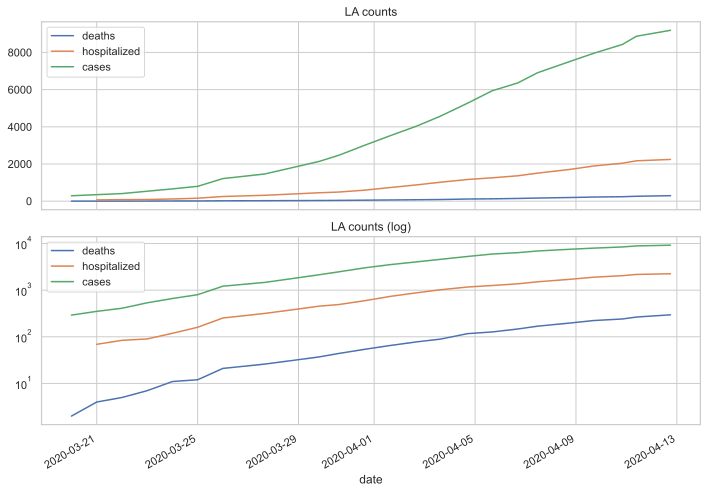

In [5]:
fig, axes = plt.subplots(nrows=2, figsize=(10,7))
lac.plot(x_compat=True, title="LA counts", ax=axes[0])
lac.plot(logy=True,  x_compat=True, title="LA counts (log)", ax=axes[1])
fig.autofmt_xdate()
fig.tight_layout()

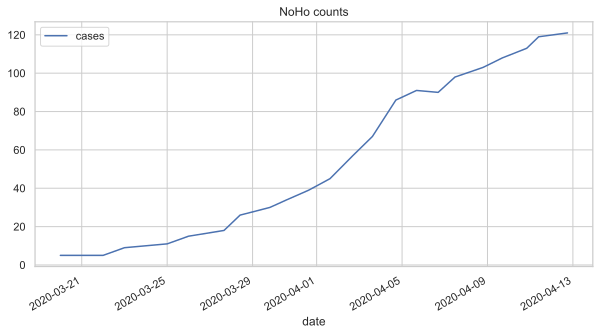

In [6]:
fig, axes = plt.subplots(nrows=1, figsize=(10,5))
noho.plot(   x_compat=True, title="NoHo counts", ax=axes)
# noho.plot(logy=True,  x_compat=True, title="NoHo counts (log)", ax=axes[1])
fig.autofmt_xdate()

# Growth (percent change from previous day)

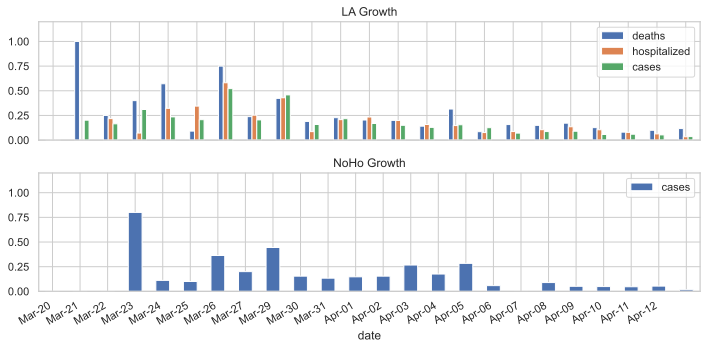

In [7]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
lac_growth.plot(kind='bar', title='LA Growth',  ax=axes[0])
noho_growth.plot(kind='bar', title='NoHo Growth',  ax=axes[1])
ticklabels = [i.strftime("%b-%d") for i, row in lac_growth.iterrows()]
axes[0].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
axes[1].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
axes[0].set_ylim((0,1.2)); axes[1].set_ylim((0,1.2))
fig.autofmt_xdate(); fig.tight_layout()

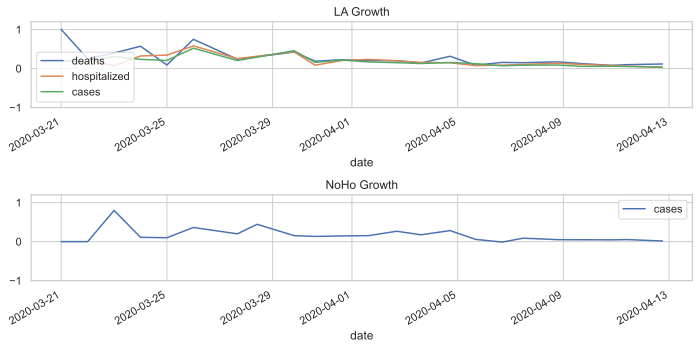

In [8]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
lac_growth.plot(x_compat=True, title='LA Growth',  ax=axes[0])
noho_growth.plot(x_compat=True, title='NoHo Growth',  ax=axes[1])
axes[0].set_ylim((-1,1.2)); axes[1].set_ylim((-1,1.2))
fig.tight_layout()

# Growth rate (ratio of day's growth to previous day's growth)

# Data
## LA County
### Cases (counts)

In [9]:
lac

deaths  hospitalized   cases
date                                                    
2020-03-20 00:00:00.000000     2.0           NaN   292.0
2020-03-21 00:00:00.000000     4.0          69.0   351.0
2020-03-22 00:00:00.000000     5.0          84.0   409.0
2020-03-23 00:00:00.000000     7.0          90.0   536.0
2020-03-24 00:00:00.000000    11.0         119.0   662.0
2020-03-25 00:00:00.000000    12.0         160.0   799.0
2020-03-26 00:00:00.000000    21.0         253.0  1216.0
2020-03-27 15:54:01.964592    26.0         317.0  1465.0
2020-03-29 19:25:50.812062    37.0         453.0  2136.0
2020-03-30 14:30:44.492110    44.0         492.0  2474.0
2020-03-31 15:02:43.233651    54.0         594.0  3011.0
2020-04-01 15:00:29.244953    65.0         733.0  3518.0
2020-04-02 16:39:05.319933    78.0         879.0  4045.0
2020-04-03 14:40:57.295335    89.0        1018.0  4566.0
2020-04-04 17:02:42.350030   117.0        1168.0  5277.0
2020-04-05 16:15:35.299912   127.0        1257.0  5940.0
2020-04-06 16:34:01.475868   147.0        1366.0  6360.0
2020-04-07 11:29:00.000000   169.0        1510.0  6910.0
2020-04-08 18:56:40.209629   198.0        1714.0  7530.0
2020-04-09 16:48:51.512612   223.0        1894.0  7955.0
2020-04-10 20:08:30.735022   241.0        2043.0  8430.0
2020-04-11 09:33:00.000000   265.0        2172.0  8873.0
2020-04-12 17:52:41.592100   296.0        2246.0  9192.0

### Growth (Pct change from previous day)

In [10]:
lac_growth.dropna(how='all')

deaths  hospitalized  cases
date                                                   
2020-03-21 00:00:00.000000    1.00           NaN   0.20
2020-03-22 00:00:00.000000    0.25          0.22   0.17
2020-03-23 00:00:00.000000    0.40          0.07   0.31
2020-03-24 00:00:00.000000    0.57          0.32   0.24
2020-03-25 00:00:00.000000    0.09          0.34   0.21
2020-03-26 00:00:00.000000    0.75          0.58   0.52
2020-03-27 15:54:01.964592    0.24          0.25   0.20
2020-03-29 19:25:50.812062    0.42          0.43   0.46
2020-03-30 14:30:44.492110    0.19          0.09   0.16
2020-03-31 15:02:43.233651    0.23          0.21   0.22
2020-04-01 15:00:29.244953    0.20          0.23   0.17
2020-04-02 16:39:05.319933    0.20          0.20   0.15
2020-04-03 14:40:57.295335    0.14          0.16   0.13
2020-04-04 17:02:42.350030    0.31          0.15   0.16
2020-04-05 16:15:35.299912    0.09          0.08   0.13
2020-04-06 16:34:01.475868    0.16          0.09   0.07
2020-04-07 11:29:00.000000    0.15          0.11   0.09
2020-04-08 18:56:40.209629    0.17          0.14   0.09
2020-04-09 16:48:51.512612    0.13          0.11   0.06
2020-04-10 20:08:30.735022    0.08          0.08   0.06
2020-04-11 09:33:00.000000    0.10          0.06   0.05
2020-04-12 17:52:41.592100    0.12          0.03   0.04

## North Hollywood
### Cases (count)

In [11]:
noho

cases
date                             
2020-03-20 00:00:00.000000    5.0
2020-03-21 00:00:00.000000    5.0
2020-03-22 00:00:00.000000    5.0
2020-03-23 00:00:00.000000    9.0
2020-03-24 00:00:00.000000   10.0
2020-03-25 00:00:00.000000   11.0
2020-03-26 00:00:00.000000   15.0
2020-03-27 15:54:01.964592   18.0
2020-03-28 09:56:35.322294   26.0
2020-03-29 19:25:50.812062   30.0
2020-03-30 14:30:44.492110   34.0
2020-03-31 15:02:43.233651   39.0
2020-04-01 15:00:29.244953   45.0
2020-04-02 16:39:05.319933   57.0
2020-04-03 14:40:57.295335   67.0
2020-04-04 17:02:42.350030   86.0
2020-04-05 16:15:35.299912   91.0
2020-04-06 16:34:01.475868   90.0
2020-04-07 11:29:00.000000   98.0
2020-04-08 18:56:40.209629  103.0
2020-04-09 16:48:51.512612  108.0
2020-04-10 20:08:30.735022  113.0
2020-04-11 09:33:00.000000  119.0
2020-04-12 17:52:41.592100  121.0

### growth  (Pct change from previous day)

In [12]:
noho_growth

cases
date                             
2020-03-20 00:00:00.000000    NaN
2020-03-21 00:00:00.000000   0.00
2020-03-22 00:00:00.000000   0.00
2020-03-23 00:00:00.000000   0.80
2020-03-24 00:00:00.000000   0.11
2020-03-25 00:00:00.000000   0.10
2020-03-26 00:00:00.000000   0.36
2020-03-27 15:54:01.964592   0.20
2020-03-28 09:56:35.322294   0.44
2020-03-29 19:25:50.812062   0.15
2020-03-30 14:30:44.492110   0.13
2020-03-31 15:02:43.233651   0.15
2020-04-01 15:00:29.244953   0.15
2020-04-02 16:39:05.319933   0.27
2020-04-03 14:40:57.295335   0.18
2020-04-04 17:02:42.350030   0.28
2020-04-05 16:15:35.299912   0.06
2020-04-06 16:34:01.475868  -0.01
2020-04-07 11:29:00.000000   0.09
2020-04-08 18:56:40.209629   0.05
2020-04-09 16:48:51.512612   0.05
2020-04-10 20:08:30.735022   0.05
2020-04-11 09:33:00.000000   0.05
2020-04-12 17:52:41.592100   0.02

# Attic

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
lac.plot(x_compat=True, title="LA counts", ax=axes[0, 0])
lac.plot(logy=True,  x_compat=True, title="LA counts (log)", ax=axes[0, 1])
noho.plot(   x_compat=True, title="NoHo counts", ax=axes[1,0])
noho.plot(logy=True,  x_compat=True, title="NoHo counts (log)", ax=axes[1,1])
fig.autofmt_xdate()
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(figsize=(10, 5))
noho.plot(logy=True,  x_compat=True, title="NoHo counts (log)", ax=axes)
# axes.set_xlim('2020-03-20', '2020-04-01')


In [13]:
import numpy as np

growth_rate = np.exp(np.diff(np.log(lac.cases))) - 1

In [14]:
growth_rate

array([0.20205479, 0.16524217, 0.31051345, 0.23507463, 0.20694864,
       0.52190238, 0.20476974, 0.45802048, 0.1582397 , 0.2170574 ,
       0.1683826 , 0.14980102, 0.12880099, 0.15571616, 0.12563957,
       0.07070707, 0.08647799, 0.08972504, 0.0564409 , 0.05971087,
       0.05255042, 0.03595176])

In [15]:
r = requests.get(url)

NameError: name 'requests' is not defined

In [ ]:
# fixing missed day
local_data.date = local_data.date - pd.Timedelta('1 day')
local_data

local_data.to_csv(make_data_filepath(LOCALITY_NAME_STEM))

In [ ]:
import requests

In [ ]:
r.content

In [ ]:
old_lac

In [ ]:
lac.pivot()

In [ ]:
local

In [ ]:
f = make_locality_filepath()

f[ -len(LOCALITY_NAME_STEM):] == LOCALITY_NAME_STEM

In [ ]:
dlac.index

In [ ]:
local_data

In [ ]:
data

In [ ]:
noho

In [ ]:
soup = BeautifulSoup( r.content, features="lxml" )


In [ ]:
soup.table

https://www.latimes.com/projects/california-coronavirus-cases-tracking-outbreak/
    
    Data inside a script tag at the bottom of the page

In [ ]:
window.STATEWIDE_TIMESERIES = [{"date":"2020-01-26","confirmed_cases":2,"deaths":0,"in_progress":false,"new_confirmed_cases":null,"new_deaths":null},{"date":"2020-01-27","confirmed_cases":2,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-01-28","confirmed_cases":2,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-01-29","confirmed_cases":2,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-01-30","confirmed_cases":2,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-01-31","confirmed_cases":3,"deaths":0,"in_progress":false,"new_confirmed_cases":1,"new_deaths":0},{"date":"2020-02-01","confirmed_cases":3,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-02","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":3,"new_deaths":0},{"date":"2020-02-03","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-04","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-05","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-06","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-07","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-08","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-09","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-10","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-11","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-12","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-13","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-14","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-15","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-16","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-17","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-18","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-19","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-20","confirmed_cases":7,"deaths":0,"in_progress":false,"new_confirmed_cases":1,"new_deaths":0},{"date":"2020-02-21","confirmed_cases":8,"deaths":0,"in_progress":false,"new_confirmed_cases":1,"new_deaths":0},{"date":"2020-02-22","confirmed_cases":8,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-23","confirmed_cases":8,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-24","confirmed_cases":8,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-25","confirmed_cases":8,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-26","confirmed_cases":9,"deaths":0,"in_progress":false,"new_confirmed_cases":1,"new_deaths":0},{"date":"2020-02-27","confirmed_cases":9,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-28","confirmed_cases":11,"deaths":0,"in_progress":false,"new_confirmed_cases":2,"new_deaths":0},{"date":"2020-02-29","confirmed_cases":13,"deaths":0,"in_progress":false,"new_confirmed_cases":2,"new_deaths":0},{"date":"2020-03-01","confirmed_cases":18,"deaths":0,"in_progress":false,"new_confirmed_cases":5,"new_deaths":0},{"date":"2020-03-02","confirmed_cases":23,"deaths":0,"in_progress":false,"new_confirmed_cases":5,"new_deaths":0},{"date":"2020-03-03","confirmed_cases":30,"deaths":0,"in_progress":false,"new_confirmed_cases":7,"new_deaths":0},{"date":"2020-03-04","confirmed_cases":40,"deaths":1,"in_progress":false,"new_confirmed_cases":10,"new_deaths":1},{"date":"2020-03-05","confirmed_cases":54,"deaths":1,"in_progress":false,"new_confirmed_cases":14,"new_deaths":0},{"date":"2020-03-06","confirmed_cases":70,"deaths":1,"in_progress":false,"new_confirmed_cases":16,"new_deaths":0},{"date":"2020-03-07","confirmed_cases":90,"deaths":1,"in_progress":false,"new_confirmed_cases":20,"new_deaths":0},{"date":"2020-03-08","confirmed_cases":101,"deaths":1,"in_progress":false,"new_confirmed_cases":11,"new_deaths":0},{"date":"2020-03-09","confirmed_cases":142,"deaths":2,"in_progress":false,"new_confirmed_cases":41,"new_deaths":1},{"date":"2020-03-10","confirmed_cases":153,"deaths":3,"in_progress":false,"new_confirmed_cases":11,"new_deaths":1},{"date":"2020-03-11","confirmed_cases":183,"deaths":4,"in_progress":false,"new_confirmed_cases":30,"new_deaths":1},{"date":"2020-03-12","confirmed_cases":237,"deaths":4,"in_progress":false,"new_confirmed_cases":54,"new_deaths":0},{"date":"2020-03-13","confirmed_cases":301,"deaths":5,"in_progress":false,"new_confirmed_cases":64,"new_deaths":1},{"date":"2020-03-14","confirmed_cases":371,"deaths":5,"in_progress":false,"new_confirmed_cases":70,"new_deaths":0},{"date":"2020-03-15","confirmed_cases":440,"deaths":6,"in_progress":false,"new_confirmed_cases":69,"new_deaths":1},{"date":"2020-03-16","confirmed_cases":571,"deaths":12,"in_progress":false,"new_confirmed_cases":131,"new_deaths":6},{"date":"2020-03-17","confirmed_cases":729,"deaths":14,"in_progress":false,"new_confirmed_cases":158,"new_deaths":2},{"date":"2020-03-18","confirmed_cases":869,"deaths":17,"in_progress":false,"new_confirmed_cases":140,"new_deaths":3},{"date":"2020-03-19","confirmed_cases":1040,"deaths":19,"in_progress":false,"new_confirmed_cases":171,"new_deaths":2},{"date":"2020-03-20","confirmed_cases":1247,"deaths":24,"in_progress":false,"new_confirmed_cases":207,"new_deaths":5},{"date":"2020-03-21","confirmed_cases":1506,"deaths":28,"in_progress":false,"new_confirmed_cases":259,"new_deaths":4},{"date":"2020-03-22","confirmed_cases":1802,"deaths":35,"in_progress":false,"new_confirmed_cases":296,"new_deaths":7},{"date":"2020-03-23","confirmed_cases":2222,"deaths":43,"in_progress":false,"new_confirmed_cases":420,"new_deaths":8},{"date":"2020-03-24","confirmed_cases":2621,"deaths":54,"in_progress":false,"new_confirmed_cases":399,"new_deaths":11},{"date":"2020-03-25","confirmed_cases":3244,"deaths":69,"in_progress":false,"new_confirmed_cases":623,"new_deaths":15},{"date":"2020-03-26","confirmed_cases":4055,"deaths":83,"in_progress":false,"new_confirmed_cases":811,"new_deaths":14},{"date":"2020-03-27","confirmed_cases":2929,"deaths":57,"in_progress":true,"new_confirmed_cases":-1126,"new_deaths":-26}];

In [ ]:
url = 'https://www.latimes.com/projects/california-coronavirus-cases-tracking-outbreak/'
r = requests.get(url)